In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import clip
from PIL import Image
import open_clip
import csv
from transformers import ViTImageProcessor, ViTModel

/opt/anaconda3/envs/NN/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
model = model.to('mps')
model = model.eval()

In [3]:
data = []
# iterate over all files in the data folder and add all images to the data list there are lots of folder in the data folder
for root, dirs, files in os.walk("data"):
    for file in files:
        if file.endswith(".jpg"):
            data.append(os.path.join(root, file))

In [4]:
n_parameters = sum(p.numel() for p in model.parameters())
print("Number of parameters:", n_parameters)

Number of parameters: 86389248


In [5]:
len(data)

118

In [6]:
embedding = []
for i in range(len(data)):
    print("Processing image", i)
    image = Image.open(data[i])
    inputs = processor(images=image, return_tensors="pt")
    inputs = inputs.to('mps')
    outputs = model(**inputs)
    last_hidden_states = outputs.last_hidden_state
    cls = last_hidden_states[:, 0, :]
    embedding.append({
        'file': data[i],
        'embedding': cls.cpu().detach().numpy()
    })

Processing image 0
Processing image 1
Processing image 2
Processing image 3
Processing image 4
Processing image 5
Processing image 6
Processing image 7
Processing image 8
Processing image 9
Processing image 10
Processing image 11
Processing image 12
Processing image 13
Processing image 14
Processing image 15
Processing image 16
Processing image 17
Processing image 18
Processing image 19
Processing image 20
Processing image 21
Processing image 22
Processing image 23
Processing image 24
Processing image 25
Processing image 26
Processing image 27
Processing image 28
Processing image 29
Processing image 30
Processing image 31
Processing image 32
Processing image 33
Processing image 34
Processing image 35
Processing image 36
Processing image 37
Processing image 38
Processing image 39
Processing image 40
Processing image 41
Processing image 42
Processing image 43
Processing image 44
Processing image 45
Processing image 46
Processing image 47
Processing image 48
Processing image 49
Processing

Performing t-SNE dimensionality reduction...

Clustering Statistics:
Cluster 0: 39 images
Cluster 1: 27 images
Cluster 2: 26 images
Cluster 3: 26 images


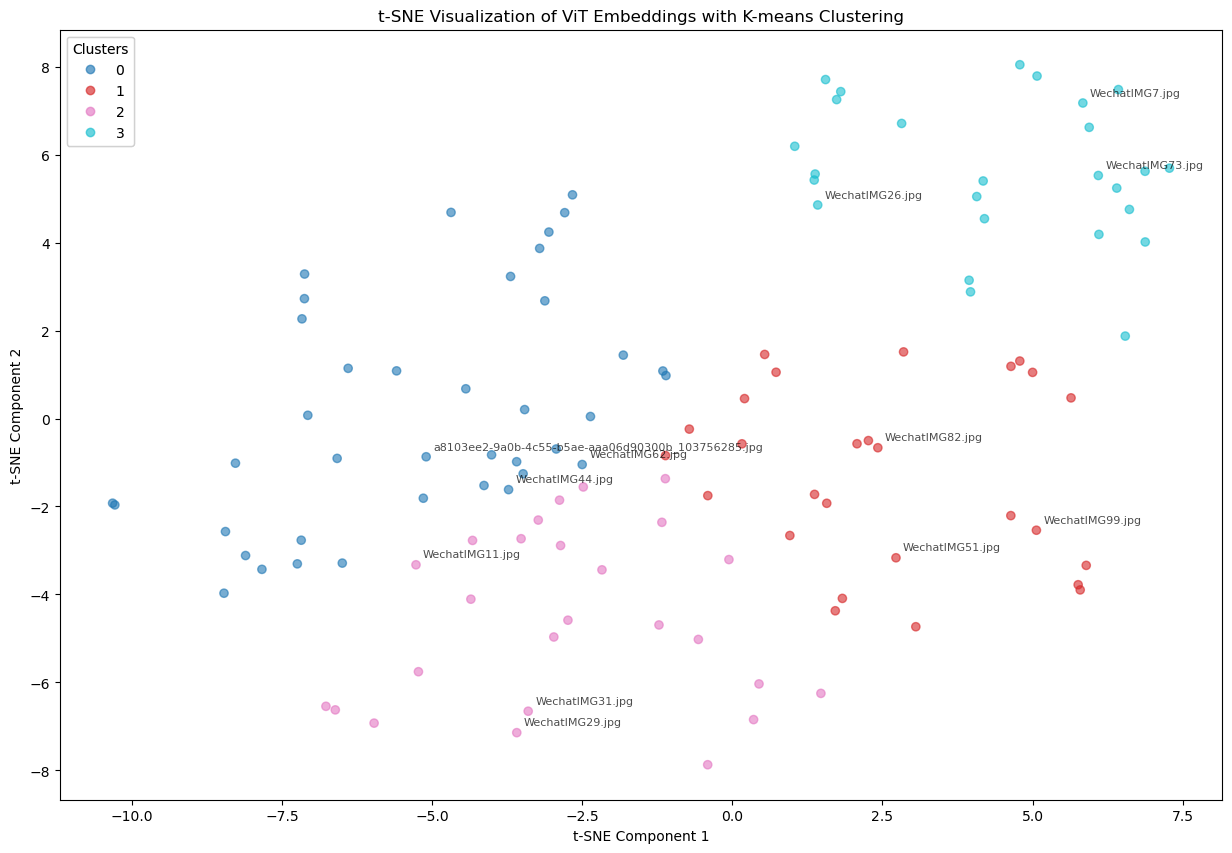

In [9]:
import numpy as np
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import os

# two hypterparameters
n_component = 2
n_clusters = 4

# Extract the embeddings and filenames from your data structure
X = np.array([item['embedding'].squeeze() for item in embedding])  # Remove extra dimension
filenames = [os.path.basename(item['file']) for item in embedding]

# Reduce dimensionality with t-SNE
print("Performing t-SNE dimensionality reduction...")
tsne = TSNE(n_components=n_component, random_state=42)
X_tsne = tsne.fit_transform(X)

# Perform K-means clustering with dimension reduced data
kmeans = KMeans(n_clusters=n_clusters)
clusters = kmeans.fit_predict(X_tsne)

# Create the visualization
plt.figure(figsize=(15, 10))

# Plot points with different colors for each cluster
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=clusters, cmap='tab10', alpha=0.6)

# Add legend
legend1 = plt.legend(*scatter.legend_elements(), title="Clusters")
plt.gca().add_artist(legend1)


for cluster_id in range(n_clusters):
    # Get indices for current cluster
    cluster_indices = np.where(clusters == cluster_id)[0]
    # Randomly select up to 3 points from this cluster
    if len(cluster_indices) > 3:
        label_indices = np.random.choice(cluster_indices, 3, replace=False)
    else:
        label_indices = cluster_indices
        
    for idx in label_indices:
        plt.annotate(filenames[idx], 
                    (X_tsne[idx, 0], X_tsne[idx, 1]),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=8, alpha=0.7)

plt.title('t-SNE Visualization of ViT Embeddings with K-means Clustering')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

# Add some statistics
print("\nClustering Statistics:")
for cluster_id in range(n_clusters):
    cluster_size = np.sum(clusters == cluster_id)
    print(f"Cluster {cluster_id}: {cluster_size} images")

# Save the plot
plt.savefig('vit_clustering.png', dpi=300, bbox_inches='tight')


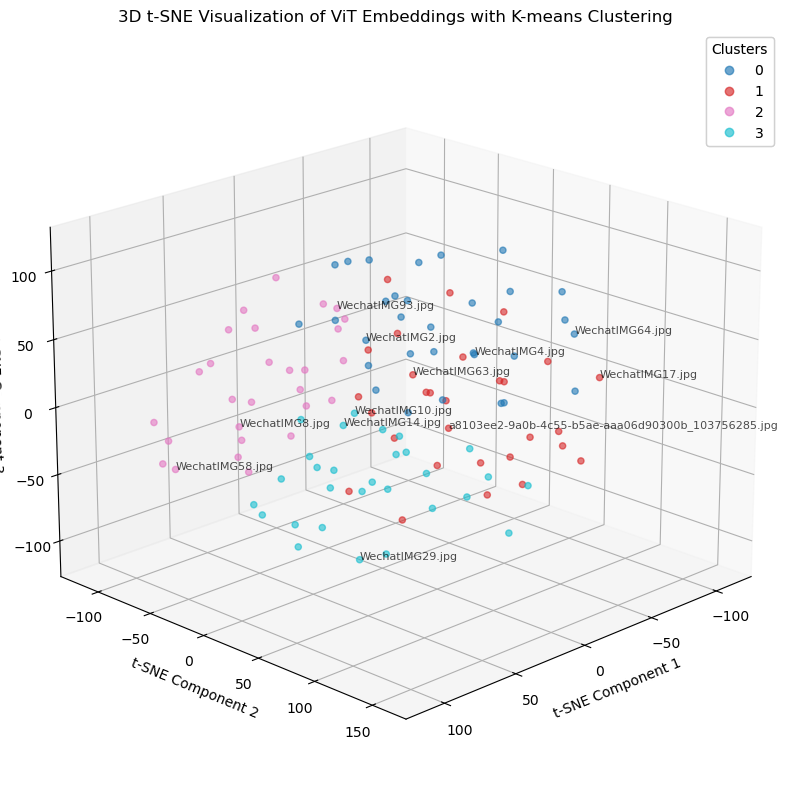

In [29]:
# Create the 3D visualization
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot points with different colors for each cluster
scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2],
                    c=clusters, cmap='tab10', alpha=0.6)

# Add legend
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

# Add labels for selected points in each cluster
for cluster_id in range(n_clusters):
    # Get indices for current cluster
    cluster_indices = np.where(clusters == cluster_id)[0]
    # Randomly select up to 3 points from this cluster
    if len(cluster_indices) > 3:
        label_indices = np.random.choice(cluster_indices, 3, replace=False)
    else:
        label_indices = cluster_indices
        
    for idx in label_indices:
        ax.text(X_tsne[idx, 0], X_tsne[idx, 1], X_tsne[idx, 2],
                filenames[idx],
                fontsize=8, alpha=0.7)

ax.set_title('3D t-SNE Visualization of ViT Embeddings with K-means Clustering')
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')

# Add some spacing between the axes and labels
ax.dist = 12

# Add rotation for better 3D visualization
ax.view_init(elev=20, azim=45)

Cluster 0: WechatIMG16.jpg | WechatIMG87.jpg | WechatIMG94.jpg | WechatIMG3.jpg | WechatIMG6.jpg | 37cbfda6-a4cc-4f70-9f72-a66af343f395_103852244.jpg | WechatIMG46.jpg | WechatIMG60.jpg | WechatIMG78.jpg | WechatIMG32.jpg
Cluster 1: WechatIMG52.jpg | WechatIMG80.jpg | WechatIMG89.jpg | WechatIMG98.jpg | WechatIMG55.jpg | WechatIMG13.jpg | WechatIMG92.jpg | WechatIMG81.jpg | WechatIMG74.jpg | WechatIMG91.jpg
Cluster 2: WechatIMG17.jpg | WechatIMG69.jpg | WechatIMG96.jpg | WechatIMG36.jpg | WechatIMG65.jpg | WechatIMG20.jpg | WechatIMG19.jpg | WechatIMG4.jpg | WechatIMG64.jpg | WechatIMG30.jpg
Cluster 3: WechatIMG59.jpg | WechatIMG8.jpg | WechatIMG7.jpg | WechatIMG43.jpg | WechatIMG10.jpg | WechatIMG6.jpg | WechatIMG25.jpg | f32784ee-1ed5-43d9-9531-5695233967e4_103536569.jpg | WechatIMG73.jpg | WechatIMG24.jpg


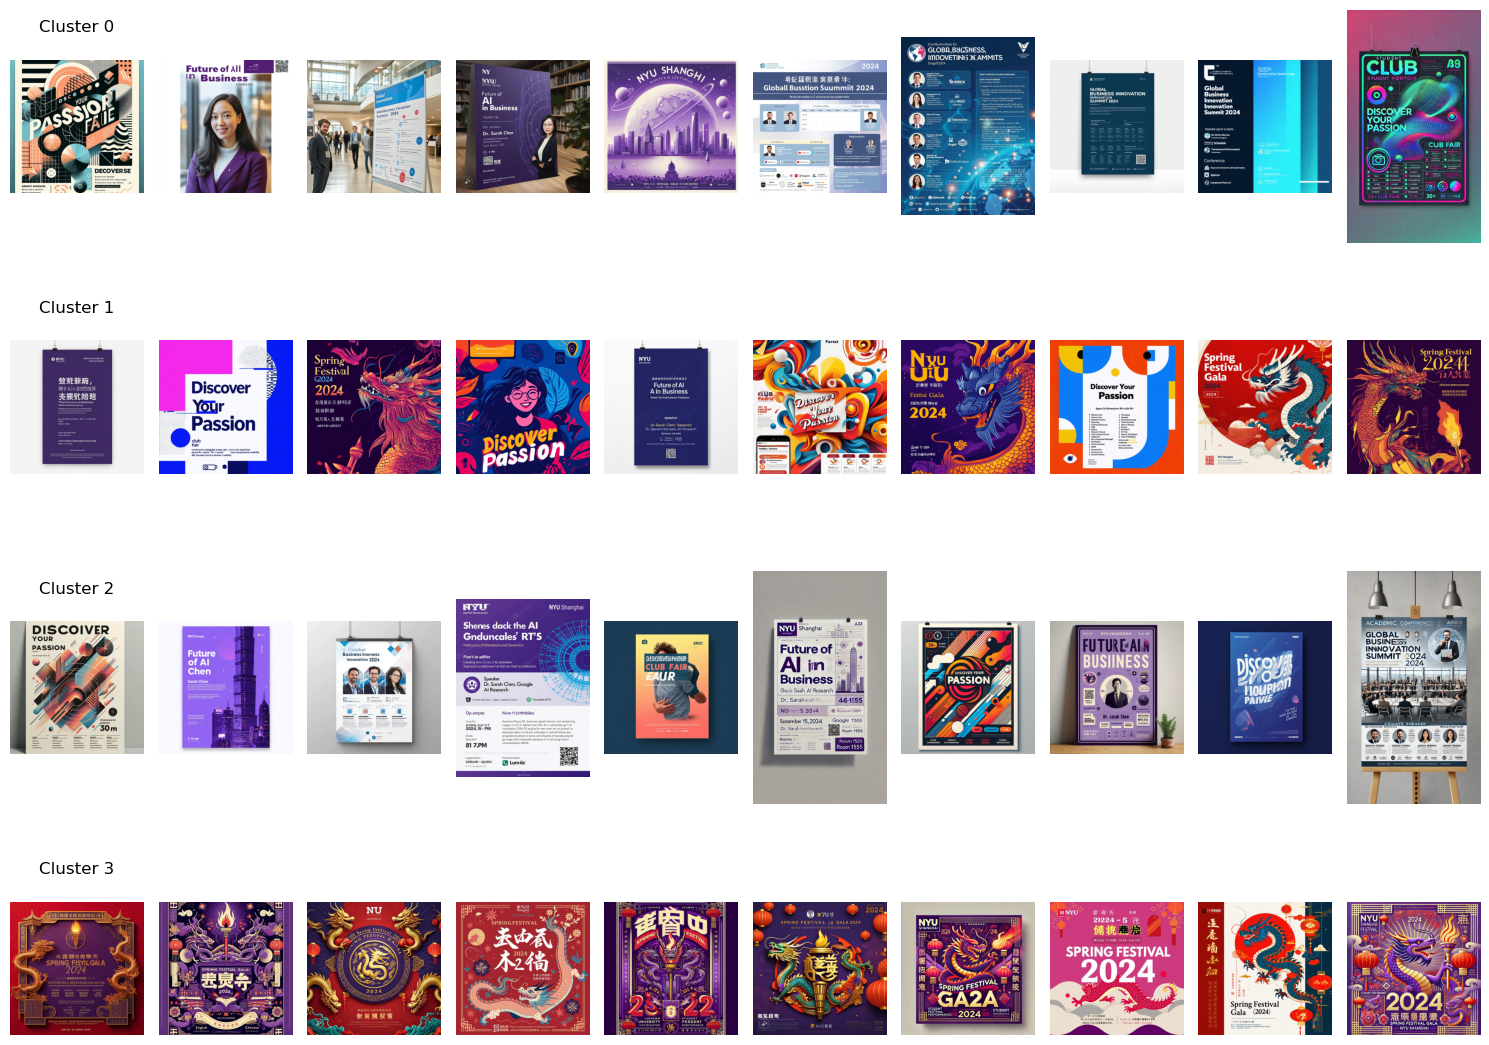

In [10]:
# Calculate grid dimensions
samples_per_cluster = 10
n_cols = samples_per_cluster
n_rows = n_clusters

# Create a figure with subplots
fig = plt.figure(figsize=(15, 3*n_clusters))

for cluster_id in range(n_clusters):
    # Get indices for current cluster
    cluster_indices = np.where(clusters == cluster_id)[0]
    
    # Select random examples from this cluster
    example_indices = np.random.choice(
        cluster_indices, 
        min(samples_per_cluster, len(cluster_indices)), 
        replace=False
    )
    
    # Create a string to store filenames
    cluster_files = []
    
    # Plot each example
    for i, idx in enumerate(example_indices):
        # Add subplot
        ax = plt.subplot(n_rows, n_cols, cluster_id * n_cols + i + 1)
        
        # Open and display image
        image = Image.open(embedding[idx]['file'])
        plt.imshow(image)
        plt.axis('off')
        
        # Store filename
        cluster_files.append(filenames[idx])
        
        # Add cluster label only to first image in row
        if i == 0:
            plt.title(f'Cluster {cluster_id}', pad=20)
    
    # Print filenames on the same line
    print(f"Cluster {cluster_id}: " + " | ".join(cluster_files))

# Adjust layout and display
plt.tight_layout()
plt.show()